Распознавание рукописного ввода на примере базы MNIST

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать [ipython-ноутбук 002-digit.ipynb](https://github.com/a4tunado/lectures/blob/master/002/002-digit.ipynb).

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста [Digit Recognizer](https://www.kaggle.com/c/digit-recognizer) на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [3]:
train_data = np.loadtxt("./data/digit/train.csv", delimiter=',', skiprows=1)
test_data = np.loadtxt("./data/digit/test.csv", delimiter=',', skiprows=1)

In [4]:
X_train, y_train = np.resize(train_data[:, 1:], (train_data.shape[0], 28, 28)), train_data[:, 0].astype(int)
X_test = np.resize(test_data, (test_data.shape[0], 28, 28))

In [5]:
X_train.shape, y_train.shape, X_test.shape

((42000, 28, 28), (42000,), (28000, 28, 28))

Понижаем размерность с помощью PCA

In [6]:
X_mean = X_train.mean(axis=0)
X_train_centered = (X_train - X_mean).reshape(-1, 28*28)

In [7]:
X_mean.shape

(28, 28)

In [8]:
X_train_centered.shape

(42000, 784)

In [9]:
cov = np.dot(X_train_centered.T, X_train_centered) / X_train_centered.shape[0]

In [10]:
U, S, _ = np.linalg.svd(cov)

In [11]:
U.shape

(784, 784)

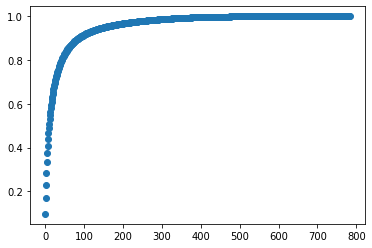

In [12]:
S_cumsum = np.cumsum(S) / np.sum(S)
plt.plot(S_cumsum, 'o')

In [13]:
S_threshold = 0.9
n_comp = np.argmax(np.where(S_cumsum > S_threshold, 1, 0))
n_comp, S_cumsum[n_comp]

(86, 0.9006115525464056)

In [14]:
U_reduced = U[:, :n_comp]
U_reduced.shape

(784, 86)

In [15]:
X_train_reduced = np.dot(X_train_centered, U_reduced)
X_train_reduced.shape

(42000, 86)

Посмотрим на восстановленное изображение произвольных символов

In [16]:
X_train_restored = np.dot(X_train_reduced, U_reduced.T)

In [17]:
sym_count = 7
sym_indexes = np.random.choice(X_train.shape[0], sym_count)

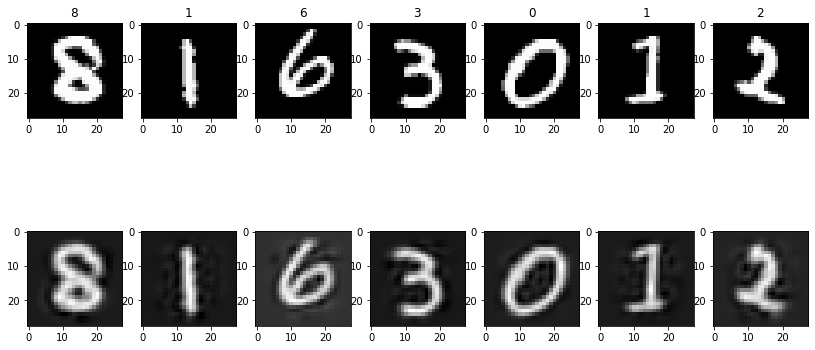

In [18]:
fig = plt.figure(figsize=(14,7))
for i in range(sym_count):
    
    # original
    subplot = fig.add_subplot(2, sym_count, i + 1)
    img = X_train_centered[sym_indexes[i]].reshape((28,28)) + X_mean
    plt.title(y_train[sym_indexes[i]])
    plt.imshow(img, cmap='gray')
    
    # reduced
    subplot = fig.add_subplot(2, sym_count, i + sym_count + 1)
    img = X_train_restored[sym_indexes[i]].reshape((28,28)) + X_mean
    plt.imshow(img, cmap='gray')

Построем классификатор, в качестве множеcтва фич будут выступать фичи полученные с помощью понижения размерности

In [19]:
model = RandomForestClassifier()

In [20]:
%%time
model.fit(X_train_reduced, y_train)

Wall time: 6.86 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Классифицируем тестовый сет

In [21]:
X_test_centered = (X_test - X_mean).reshape(-1, 28*28)
X_test_reduced = np.dot(X_test_centered, U_reduced)

In [22]:
y_test_pred = model.predict(X_test_reduced)

Визуализиуем некоторые из предсказанных символов

In [23]:
sym_lines = 3
sym_per_line = 7
sym_indexes = np.random.choice(X_test.shape[0], sym_lines * sym_per_line)

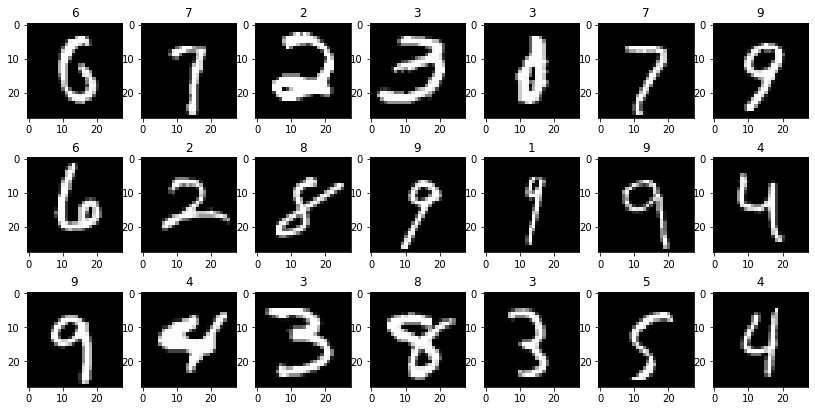

In [24]:
fig = plt.figure(figsize=(14,7))
for line in range(sym_lines):
    for col in range(sym_per_line):
        i = line * sym_per_line + col
        subplot = fig.add_subplot(sym_lines, sym_per_line, i + 1)
        img = X_test[sym_indexes[i]]
        plt.title(y_test_pred[sym_indexes[i]])
        plt.imshow(img, cmap='gray')

Файл для сабмита на kaggle

In [25]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_test_pred, 1):
        dst.write('%s,%s\n' % (i, p))